##Import Functions and load data 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras import metrics
from keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from keras.layers import Input, Dense, Embedding, SimpleRNN, Dropout, concatenate, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow as tf 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from google.colab import drive
from sklearn.model_selection import train_test_split

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#%cd /content/drive/My Drive/BT4222/Project Dataset/my_dir
md = pd.read_csv('masterdata.csv')

In [ ]:
md = md.drop(columns=['Unnamed: 0', 'category', 'label', 'text_', 'lang', 'cleaned_text']) # drop cleaned_text since unlemmatised performed better

In [ ]:
X = md.drop(columns=['target'])
X = X.loc[:, :]
y = pd.DataFrame(md.loc[:,'target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2) #20% test

In [ ]:
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (32289, 14)
X_test shape: (8073, 14)
y_train shape: (32289, 1)
y_test shape: (8073, 1)


##Tokenisation

In [ ]:
#tokenisation first
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000) #limit vocab size to 5000
tokenizer.fit_on_texts(X_train['clean_text'])

X_train_token = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_token = tokenizer.texts_to_sequences(X_test['clean_text'])

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
len(X_train_token)

32289

In [ ]:
X_train_token[:2]

[[346, 28, 812, 410, 705, 2, 205, 1, 83, 11, 25, 1126, 4, 14, 1648, 82, 1850],
 [32, 12, 6, 255, 30, 104, 4, 12, 6, 7, 75, 5, 63, 284, 2799, 3829]]

In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100 #we only use first 100 words to predict 

#sequential cols
X_train_padded = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_token, padding='post', maxlen=maxlen)

In [ ]:
X_train_padded

array([[346,  28, 812, ...,   0,   0,   0],
       [ 32,  12,   6, ...,   0,   0,   0],
       [267,  88,   7, ...,   5, 501, 188],
       ...,
       [  8,  13,   3, ...,   0,   0,   0],
       [  2,  16, 102, ...,   0,   0,   0],
       [ 55,   1,  93, ...,   0,   0,   0]], dtype=int32)

In [ ]:
#retain numerical cols
X_train = X_train.drop(columns=['clean_text'])
X_test = X_test.drop(columns=['clean_text'])

In [ ]:
#view list of words
tokenizer_cols = list(tokenizer.word_index.keys())
tokenizer_cols

In [ ]:
X_train.head()

,rating,review_length,end_with_punc,category_Books_5,category_Clothing_Shoes_and_Jewelry_5,category_Electronics_5,category_Home_and_Kitchen_5,category_Kindle_Store_5,category_Movies_and_TV_5,category_Pet_Supplies_5,category_Sports_and_Outdoors_5,category_Tools_and_Home_Improvement_5,category_Toys_and_Games_5
36445,5.0,311,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34690,5.0,34,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34747,1.0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4212,5.0,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
23402,5.0,212,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


##Simple RNN with normal embedding (test acc: 78.35%)


In [ ]:
embedding_dim = 50 

# DEFAULT n = 128

text_input = Input(shape = (maxlen,))
numerical_input = Input(shape = X_train.shape[1:])
emb = (Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        input_length=100, #maxlen set above is 100
                        trainable=True))(text_input)

text_output = SimpleRNN(units=128)(emb) 
concat = concatenate([text_output, numerical_input]) 

classifier = Dense(128, activation='relu')(concat) 
hidden = Dense(64, activation='relu')(classifier) 
output = Dense(1, activation='sigmoid')(hidden) #output layer sigmoid as binary

simple_RNNmodel = Model(inputs=[text_input , numerical_input], outputs = output)

simple_RNNmodel.compile(loss=BinaryCrossentropy(), optimizer = Adam(learning_rate=0.001), metrics=['accuracy',metrics.Precision(), metrics.Recall(),metrics.AUC()])
simple_RNNmodel.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3) #monitor val loss to prevent overfitting
history_rnn = simple_RNNmodel.fit([X_train_padded, X_train.to_numpy()],
                                  y_train, 
                                  batch_size=32, 
                                  epochs=10, 
                                  callbacks=[callback],
                                  validation_split=0.2,
                                  verbose=2) 


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 50)      1887700     ['input_3[0][0]']                
                                                                                                  
 simple_rnn_1 (SimpleRNN)       (None, 128)          22912       ['embedding_1[0][0]']            
                                                                                                  
 input_4 (InputLayer)           [(None, 13)]         0           []                               
                                                                                            

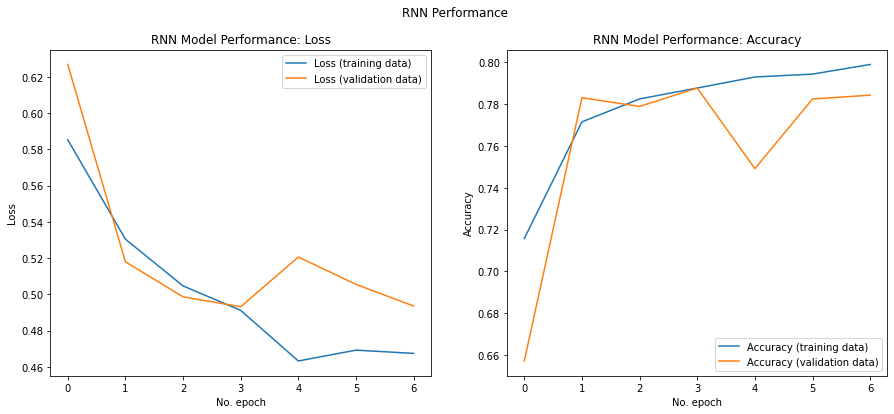

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('RNN Performance')

ax1.plot(history_rnn.history['loss'], label='Loss (training data)')
ax1.plot(history_rnn.history['val_loss'], label='Loss (validation data)')
ax1.set_title('RNN Model Performance: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history_rnn.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history_rnn.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('RNN Model Performance: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [ ]:
#evaluate training accuracies
scores = simple_RNNmodel.evaluate([X_train_padded,X_train], y_train, verbose=False)
acc = scores[1]
precision = scores[2]
recall = scores[3]
auc = scores[4]
print("Training Accuracy: %.2f%%\n" % (acc*100))
print("Precision: %.2f%%\n" % (precision*100))
print("Recall: %.2f%%\n" % (recall*100))
f1 = 2*(precision * recall)/(precision + recall)
print("F1 Score: %.2f%%\n" % (f1*100))
print("Area Under Curve: %.2f%%\n" % (auc*100))

Training Accuracy: 80.43%

Precision: 82.67%

Recall: 77.03%

F1 Score: 79.75%

Area Under Curve: 85.67%



In [ ]:
#evaluate test accuracies
scores = simple_RNNmodel.evaluate([X_test_padded,X_test], y_test, verbose=False)
acc = scores[1]
precision = scores[2]
recall = scores[3]
auc = scores[4]
print("Testing Accuracy: %.2f%%\n" % (acc*100))
print("Precision: %.2f%%\n" % (precision*100))
print("Recall: %.2f%%\n" % (recall*100))
f1 = 2*(precision * recall)/(precision + recall)
print("F1 Score: %.2f%%\n" % (f1*100))
print("Area Under Curve: %.2f%%\n" % (auc*100))

Testing Accuracy: 78.35%

Precision: 79.53%

Recall: 76.09%

F1 Score: 77.77%

Area Under Curve: 81.63%



##Simple RNN with GloVe (test acc : 80.03%)



In [ ]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    "glove.6B.50d.txt",
    tokenizer.word_index, embedding_dim)

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8150924405361021

In [ ]:
# DEFAULT n = 128
text_input = Input(shape = (maxlen,))
numerical_input = Input(shape = X_train.shape[1:])
emb = Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           weights=[embedding_matrix],
                           input_length=100, 
                           trainable=True)(text_input)

text_output = SimpleRNN(units=128)(emb) 
concat = concatenate([text_output, numerical_input]) 
classifier = Dense(128, activation='relu')(concat) 
hidden = Dense(64, activation='relu')(classifier) 
output = Dense(1, activation='sigmoid')(hidden) 
simple_RNNmodel_glove = Model(inputs=[text_input , numerical_input], outputs = output)

simple_RNNmodel_glove.compile(loss=BinaryCrossentropy(), optimizer = Adam(learning_rate=0.001), metrics=['accuracy',metrics.Precision(), metrics.Recall(),metrics.AUC()])
simple_RNNmodel_glove.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3) 

history_rnn_glove = simple_RNNmodel_glove.fit([X_train_padded, X_train.to_numpy()],
                                              y_train, 
                                              batch_size=32, 
                                              epochs=10, 
                                              callbacks=[callback],
                                              validation_split=0.2,
                                              verbose=2) 


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 100, 50)      1887700     ['input_7[0][0]']                
                                                                                                  
 simple_rnn_3 (SimpleRNN)       (None, 128)          22912       ['embedding_3[0][0]']            
                                                                                                  
 input_8 (InputLayer)           [(None, 13)]         0           []                               
                                                                                            

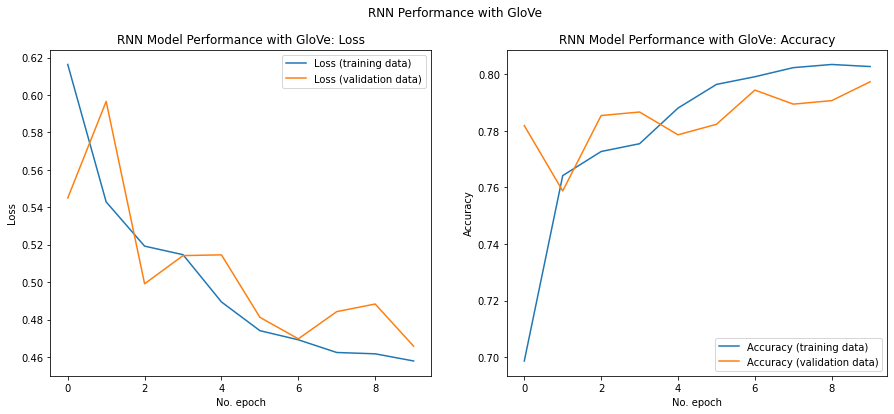

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('RNN Performance with GloVe')

ax1.plot(history_rnn_glove.history['loss'], label='Loss (training data)')
ax1.plot(history_rnn_glove.history['val_loss'], label='Loss (validation data)')
ax1.set_title('RNN Model Performance with GloVe: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(history_rnn_glove.history['accuracy'], label='Accuracy (training data)')
ax2.plot(history_rnn_glove.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('RNN Model Performance with GloVe: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [ ]:
#evaluate training accuracies
scores = simple_RNNmodel_glove.evaluate([X_train_padded,X_train], y_train, verbose=False)
acc = scores[1]
precision = scores[2]
recall = scores[3]
auc = scores[4]
print("Training Accuracy: %.2f%%\n" % (acc*100))
print("Precision: %.2f%%\n" % (precision*100))
print("Recall: %.2f%%\n" % (recall*100))
f1 = 2*(precision * recall)/(precision + recall)
print("F1 Score: %.2f%%\n" % (f1*100))
print("Area Under Curve: %.2f%%\n" % (auc*100))

Training Accuracy: 80.37%

Precision: 86.40%

Recall: 72.11%

F1 Score: 78.61%

Area Under Curve: 85.75%



In [ ]:
#evaluate test accuracies
scores = simple_RNNmodel_glove.evaluate([X_test_padded,X_test], y_test, verbose=False)
acc = scores[1]
precision = scores[2]
recall = scores[3]
auc = scores[4]
print("Testing Accuracy: %.2f%%\n" % (acc*100))
print("Precision: %.2f%%\n" % (precision*100))
print("Recall: %.2f%%\n" % (recall*100))
f1 = 2*(precision * recall)/(precision + recall)
print("F1 Score: %.2f%%\n" % (f1*100))
print("Area Under Curve: %.2f%%\n" % (auc*100))

Testing Accuracy: 80.03%

Precision: 86.37%

Recall: 71.11%

F1 Score: 78.00%

Area Under Curve: 84.29%



#Hyperparameter tuning using RandomSearchCV
1. Embedding Dimension [50, 100, 150]
2. Hidden Units [32, 64, 128]
3. Drop-out Rate [0.1, 0.2, 0.3]
4. Learning Rate [0.0001, 0.001]
5. Batch Size [32, 64, 128]

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
#glove to be used
def create_model(embedding_dim, batch_size, hidden_units, dropout_rate, learning_rate):
  maxlen =100
  if embedding_dim == 50:
      emb_matrix = create_embedding_matrix("glove.6B.50d.txt", tokenizer.word_index, embedding_dim)
  elif embedding_dim == 100:
      emb_matrix = create_embedding_matrix("glove.6B.100d.txt", tokenizer.word_index, embedding_dim)
  else:
      emb_matrix = create_embedding_matrix("glove.6B.200d.txt", tokenizer.word_index, embedding_dim)
  
  combi_input = Input((113,)) 
  text_input = Lambda(lambda x: x[:,:maxlen])(combi_input) 
  numerical_input = Lambda(lambda x: x[:,maxlen:],-1)(combi_input) #take aft text 

  emb = Embedding(input_dim=vocab_size, 
                            output_dim=embedding_dim, 
                            weights=[emb_matrix],
                            input_length=100, 
                            trainable=True)(text_input)

  text_output = SimpleRNN(units=hidden_units)(emb) 
  concat = concatenate([text_output, numerical_input]) 

  dropout1 = Dropout(dropout_rate)(concat)
  hidden1 = Dense(hidden_units, activation='relu')(dropout1) 
  dropout2 = Dropout(dropout_rate)(hidden1)
  hidden2 = Dense(hidden_units/2, activation='relu')(dropout2) 
  dropout3 = Dropout(dropout_rate)(hidden2)
  output = Dense(1, activation='sigmoid')(dropout3) #output layer sigmoid as binary

  tuned_RNNmodel_glove = Model(inputs=[combi_input], outputs = output)

  tuned_RNNmodel_glove.compile(loss=BinaryCrossentropy(), optimizer = Adam(learning_rate=learning_rate), metrics=['accuracy',metrics.Precision(), metrics.Recall(),metrics.AUC()])
  tuned_RNNmodel_glove.summary()

  return tuned_RNNmodel_glove

In [ ]:
print(pd.DataFrame(np.hstack((X_train_padded, X_train))).shape)

(32289, 113)


In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      mode='min', 
                                      verbose=2, 
                                      patience=10)

#creates model callback to save model with the lowest val loss
mc = ModelCheckpoint('Best_tuned_RNN_final.h5', 
                     monitor='val_loss',
                     mode='min',
                     verbose=2, 
                     save_best_only=True)

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs = 50)

# define gridsearch parameters
param_grid = dict(embedding_dim=[50,100,150],
                  hidden_units=[32,64,128],
                  dropout_rate=[0.1,0.2,0.3],
                  learning_rate=[0.0001,0.0005],
                  batch_size=[32,64,128])

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, verbose=2, error_score = 'raise')
# fit on training set
X_train_concat = np.hstack((X_train_padded, X_train.to_numpy()))
grid_result = grid.fit(X_train_concat, y_train,
                        verbose=2,
                        validation_split=0.2,
                        callbacks = [es, mc])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 113)]        0           []                               
                                                                                                  
 lambda_4 (Lambda)              (None, 100)          0           ['input_3[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 100)     3760400     ['lambda_4[0][0]']               
                                                                                                  
 simple_rnn_2 (SimpleRNN)       (None, 128)          29312       ['embedding_2[0][0]']            
                                 

In [ ]:
print('Best Score: %s' % grid_result.best_score_)
print('Best Hyperparameters: %s' % grid_result.best_params_)

Best Score: 0.8473473985989889
Best Hyperparameters: {'learning_rate': 0.0001, 'hidden_units': 128, 'embedding_dim': 100, 'dropout_rate': 0.1, 'batch_size': 128}


#Simple RNN with GloVe, tuned parameters  (test acc: 92.48%)

In [ ]:
X_test_concat = np.hstack((X_test_padded, X_test.to_numpy()))
X_train_concat = np.hstack((X_train_padded, X_train.to_numpy()))

In [ ]:
##run model again with specified parameters
emb_matrix = create_embedding_matrix("glove.6B.100d.txt", tokenizer.word_index, 100)
embedding_dim = 100
hidden_units = 64
dropout_rate = 0.1
learning_rate = 0.0001
max_len = 100
batch_size = 128

combi_input = Input((113,)) 
text_input = Lambda(lambda x: x[:,:maxlen])(combi_input) 
numerical_input = Lambda(lambda x: x[:,maxlen:],-1)(combi_input) #take aft text 

emb = Embedding(input_dim=vocab_size, 
                          output_dim=embedding_dim, 
                          weights=[emb_matrix],
                          input_length=100, 
                          trainable=True)(text_input)

text_output = SimpleRNN(units=hidden_units)(emb) 
concat = concatenate([text_output, numerical_input]) 

dropout1 = Dropout(dropout_rate)(concat)
hidden1 = Dense(hidden_units, activation='relu')(dropout1) 
dropout2 = Dropout(dropout_rate)(hidden1)
hidden2 = Dense(hidden_units/2, activation='relu')(dropout2) 
dropout3 = Dropout(dropout_rate)(hidden2)
output = Dense(1, activation='sigmoid')(dropout3) #output layer sigmoid as binary


tuned_RNNmodel_glove_best = Model(inputs=[combi_input], outputs = output)
tuned_RNNmodel_glove_best.compile(loss=BinaryCrossentropy(), optimizer = Adam(learning_rate=learning_rate), metrics=['accuracy',metrics.Precision(), metrics.Recall(),metrics.AUC()])
tuned_RNNmodel_glove_best.summary()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
               mode='min', 
               patience=10)

mc = ModelCheckpoint('best_RNN_model.hdf5', 
                 monitor='val_loss',
                 mode='min',
                 verbose=1, 
                 save_best_only=True)

tuned_history_rnn_glove_best = tuned_RNNmodel_glove_best.fit(X_train_concat,
                                              y_train, 
                                              batch_size=batch_size, 
                                              epochs=50, 
                                              callbacks=[es, mc],
                                              validation_split=0.2,
                                              verbose=2) 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 113)]        0           []                               
                                                                                                  
 lambda_2 (Lambda)              (None, 100)          0           ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     3760400     ['lambda_2[0][0]']               
                                                                                                  
 simple_rnn_1 (SimpleRNN)       (None, 128)          29312       ['embedding_1[0][0]']            
                                                                                            

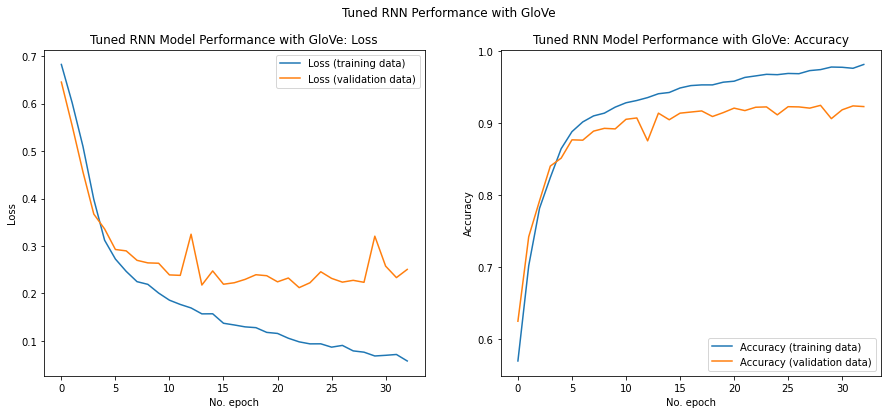

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Tuned RNN Performance with GloVe')

ax1.plot(tuned_history_rnn_glove_best.history['loss'], label='Loss (training data)')
ax1.plot(tuned_history_rnn_glove_best.history['val_loss'], label='Loss (validation data)')
ax1.set_title('Tuned RNN Model Performance with GloVe: Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('No. epoch')
ax1.legend(loc="upper right")

ax2.plot(tuned_history_rnn_glove_best.history['accuracy'], label='Accuracy (training data)')
ax2.plot(tuned_history_rnn_glove_best.history['val_accuracy'], label='Accuracy (validation data)')
ax2.set_title('Tuned RNN Model Performance with GloVe: Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('No. epoch')
ax2.legend(loc="lower right")

In [ ]:
model = load_model('best_RNN_model.hdf5')

loss, accuracy, precision, recall, auc = model.evaluate(X_test_concat, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}%".format(accuracy*100))
print("Precision: {:.4f}%".format(precision*100))
print("Recall: {:.4f}%".format(recall*100))
f1 = 2*(precision*recall)/(precision+recall)
print("F1 Score: {:.4f}%".format(f1*100))
print("Area under Curve: {:.4f}%".format(auc*100))

Testing Accuracy:  92.4811%
Precision: 93.4916%
Recall: 91.2329%
F1 Score: 92.3484%
Area under Curve: 97.6307%
